# **Import Libraries**

In [2]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  # Membagi dataset menjadi data latih dan data uji

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Loading and Cleaning**

In [3]:
df = pd.read_csv('app_review2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  75272 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          3444 non-null    object
 9   repliedAt             3444 non-null    object
 10  appVersion            75272 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [4]:
df.shape

(103500, 11)

In [5]:
review = df[['content']].copy()
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  103500 non-null  object
dtypes: object(1)
memory usage: 808.7+ KB


In [6]:
review.duplicated().sum()

np.int64(69)

In [7]:
review = review.drop_duplicates()
review.duplicated().sum()

np.int64(0)

In [8]:
reviews = review.sample(n=50000, random_state=32).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
reviews.head(100)

,content
0,"aplikasi sering bug dan hp langsung mulai ulang, harus sering hapus dan download lagi"
1,"Bagus cuma kadang ga bisa di update, sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya"
2,"Kpda cs tik tok,knpa sya gk bisa login ke akun utama sya yg dlu.di akun itu sya susah payah mendapat kn folower.(Kenapa sya tidak dapat menggirim otp ke email sya,pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp,tolong bantu sya.please help me"
3,"Aku lumayan sukaya sama apk ini,kenapa sih aku kalau buat video pasti gk ada yang ngelike,tolong perbarui apk ini nanti aku kasih bintang lima,Terima kasih🙏"
4,"pas mau liat video yg disimpan atau lagi scroll kadang suka ngefreeze videonya, padahal jaringan bagus, penyimpanan pun aman, semoga aja ini didengar"
...,...
95,"Orang : bermanfaat dan berguna, alhamdulilah 👍🤲🏻🥺"
96,"Sampek capet yg download aplikasi ini ,tiap mau buka pasti harus download lagi"
97,"Didalam aplikasi ini banyak sekali yang sesat-sesat, dan banyak banget cewek-cewek bohay dan robrut tiktok juga banyak anak-anak jadinya jangan upload video joget-joget ya kakak-kakak 🙏🙏"
98,kenapa setelah update pasti selalu stuck logo saja jadi macet dan gabisa diapain² lagi


# **Data Preprocessing**

### **Functions for data preprocessing**

In [9]:
import re
import unicodedata
import string
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# pastikan stopwords dan tokenizer sudah diunduh (sekali saja di awal)
nltk.download('stopwords')
nltk.download('punkt')

# ========== 1️⃣ Cleaning ==========
def cleaningText(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # hapus hashtag
    text = re.sub(r'RT[\s]', '', text)           # hapus retweet
    text = re.sub(r"http\S+", '', text)          # hapus URL
    text = re.sub(r'[0-9]+', '', text)           # hapus angka
    text = re.sub(r'[,.\/]', ' ', text)          # ubah tanda baca jadi spasi
    text = re.sub(r'[^\w\s]', ' ', text)         # hapus simbol non-alfanumerik
    text = re.sub(r'[²]+', '', text)             # hapus karakter aneh
    text = text.replace('\n', ' ')               # hapus newline
    text = re.sub(r'\s+', ' ', text).strip()     # hapus spasi ganda
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca sisa
    text = text.strip()
    return text

# ========== 2️⃣ Casefolding ==========
def casefoldingText(text):
    return text.lower()

# ========== 3️⃣ Tokenizing ==========
def tokenizingText(text):
    return word_tokenize(text)

# ========== 4️⃣ Filtering (Stopwords) ==========
def filteringText(words):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(stopwords.words('english'))
    listStopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'mah', 'kak', 'bolak', 'nge', 'nih', 'deh', 
        'loh', 'yah', 'wkwk', 'hihi', 'hehe', 'hahaha', 'gitu', 'nge', 'trus', 'terus', 'orang', 'logo',
        'hehehe', 'wkwkwk', 'yuk', 'dong', 'loh', 'yah', 'kok', 'gue', 'loh', 'si', 'siapa',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy', 'tuh', 'tiktok'
    ])

    listStopwords = [w for w in listStopwords if w not in ['tidak', 'bukan', 'kurang']]
    filtered = [word for word in words if word not in listStopwords]
    return filtered

# ========== 5️⃣ Stemming ==========
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_corpus(corpus):
    unique_words = set(' '.join(corpus).split())
    stem_dict = {w: stemmer.stem(w) for w in unique_words}
    return [' '.join(stem_dict[w] for w in text.split()) for text in corpus]

# ========== 6️⃣ Gabung kata jadi kalimat lagi ==========
def toSentence(list_words):
    return ' '.join(list_words)

# ========== 7️⃣ Slangword Normalization ==========
with open("slangwords_clean_final.json", "r", encoding="utf-8") as f:
    slangwords = json.load(f)

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

def handle_negation(text):
    words = text.split()
    new_words = []
    skip_next = False
    for i in range(len(words)):
        if skip_next:
            skip_next = False
            continue
        if words[i] in ['tidak', 'gak', 'nggak', 'bukan', 'kurang'] and i+1 < len(words):
            new_words.append(words[i] + '_' + words[i+1])  # jadi "tidak_profesional"
            skip_next = True
        else:
            new_words.append(words[i])
    return ' '.join(new_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Apply functions to data**

In [10]:
reviews['text_clean'] = reviews['content'].apply(cleaningText)
reviews['text_casefoldingText'] = reviews['text_clean'].apply(casefoldingText)
reviews['text_slangwords'] = reviews['text_casefoldingText'].apply(fix_slangwords)
reviews['text_negation'] = reviews['text_slangwords'].apply(handle_negation)
reviews['text_tokenizingText'] = reviews['text_negation'].apply(tokenizingText)
reviews['text_stopword'] = reviews['text_tokenizingText'].apply(filteringText)
reviews['text_akhir'] = reviews['text_stopword'].apply(toSentence)

In [249]:
reviews2 = reviews[['text_akhir', 'score']].copy()
reviews2.to_csv('reviews3.csv', index=False)

In [11]:
reviews.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_negation,text_tokenizingText,text_stopword,text_akhir
0,"aplikasi sering bug dan hp langsung mulai ulang, harus sering hapus dan download lagi",aplikasi sering bug dan hp langsung mulai ulang harus sering hapus dan download lagi,aplikasi sering bug dan hp langsung mulai ulang harus sering hapus dan download lagi,aplikasi sering galat dan ponsel langsung mulai ulang harus sering hapus dan unduh lagi,aplikasi sering galat dan ponsel langsung mulai ulang harus sering hapus dan unduh lagi,"[aplikasi, sering, galat, dan, ponsel, langsung, mulai, ulang, harus, sering, hapus, dan, unduh, lagi]","[aplikasi, galat, ponsel, langsung, ulang, hapus, unduh]",aplikasi galat ponsel langsung ulang hapus unduh
1,"Bagus cuma kadang ga bisa di update, sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya",Bagus cuma kadang ga bisa di update sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya,bagus cuma kadang ga bisa di update sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya,bagus hanya kadang tidak bisa di perbarui sekali nya di hapus terus unduh lagi memang sudah ke perbarui hanya kalau aplikasi nya di tutup balek lagi jadi perbarui sebelum nya,bagus hanya kadang tidak_bisa di perbarui sekali nya di hapus terus unduh lagi memang sudah ke perbarui hanya kalau aplikasi nya di tutup balek lagi jadi perbarui sebelum nya,"[bagus, hanya, kadang, tidak_bisa, di, perbarui, sekali, nya, di, hapus, terus, unduh, lagi, memang, sudah, ke, perbarui, hanya, kalau, aplikasi, nya, di, tutup, balek, lagi, jadi, perbarui, sebelum, nya]","[bagus, kadang, tidak_bisa, perbarui, hapus, unduh, perbarui, aplikasi, tutup, balek, perbarui]",bagus kadang tidak_bisa perbarui hapus unduh perbarui aplikasi tutup balek perbarui
2,"Kpda cs tik tok,knpa sya gk bisa login ke akun utama sya yg dlu.di akun itu sya susah payah mendapat kn folower.(Kenapa sya tidak dapat menggirim otp ke email sya,pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp,tolong bantu sya.please help me",Kpda cs tik tok knpa sya gk bisa login ke akun utama sya yg dlu di akun itu sya susah payah mendapat kn folower Kenapa sya tidak dapat menggirim otp ke email sya pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp tolong bantu sya please help me,kpda cs tik tok knpa sya gk bisa login ke akun utama sya yg dlu di akun itu sya susah payah mendapat kn folower kenapa sya tidak dapat menggirim otp ke email sya pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp tolong bantu sya please help me,kpda cs tiktok tiktok kenapa saya tidak bisa login ke akun utama saya yang dulu di akun itu saya susah payah mendapat kan pengikut kenapa saya tidak dapat menggirim otp ke surel saya padahal saya sdah me masuk kan surel dnggn benar kenapa di bisa menerima otp tolong bantu saya tolong tolong me,kpda cs tiktok tiktok kenapa saya tidak_bisa login ke akun utama saya yang dulu di akun itu saya susah payah mendapat kan pengikut kenapa saya tidak_dapat menggirim otp ke surel saya padahal saya sdah me masuk kan surel dnggn benar kenapa di bisa menerima otp tolong bantu saya tolong tolong me,"[kpda, cs, tiktok, tiktok, kenapa, saya, tidak_bisa, login, ke, akun, utama, saya, yang, dulu, di, akun, itu, saya, susah, payah, mendapat, kan, pengikut, kenapa, saya, tidak_dapat, menggirim, otp, ke, surel, saya, padahal, saya, sdah, me, masuk, kan, surel, dnggn, benar, kenapa, di, bisa, menerima, otp, tolong, bantu, saya, tolong, tolong, me]","[kpda, cs, tidak_bisa, login, akun, utama, akun, susah, payah, pengikut, tidak_dapat, menggirim, otp, surel, sdah, masuk, surel, dnggn, menerima, otp, tolong, bantu, tolong, tolong]",kpda cs tidak_bisa login akun utama akun susah payah pengikut tidak_dapat menggirim otp sur

# **Labelling**

In [17]:
import requests
import csv
from io import StringIO

lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/positive.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/negative.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")




In [16]:
import csv

lexicon_positive = {}
try:
    with open('lexicon_positive.csv', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')  # pakai ; karena isi file pakai titik koma
        for row in reader:
            try:
                lexicon_positive[row[0].strip()] = int(float(row[1].replace(',', '.')))
            except ValueError as ve:
                print(f"Baris invalid dilewati: {row} - Error: {ve}")
except FileNotFoundError:
    print("File lexicon_positive.csv tidak ditemukan.")


lexicon_negative = {}
try:
    with open('lexicon_negative.csv', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')  # pakai ; karena isi file pakai titik koma
        for row in reader:
            try:
                lexicon_positive[row[0].strip()] = int(float(row[1].replace(',', '.')))
            except ValueError as ve:
                print(f"Baris invalid dilewati: {row} - Error: {ve}")
except FileNotFoundError:
    print("File lexicon_positive.csv tidak ditemukan.")


In [18]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [19]:
results = reviews['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
reviews['polarity_score'] = results[0]
reviews['polarity'] = results[1]
print(reviews['polarity'].value_counts())

polarity
negative    33112
positive    12604
neutral      4284
Name: count, dtype: int64


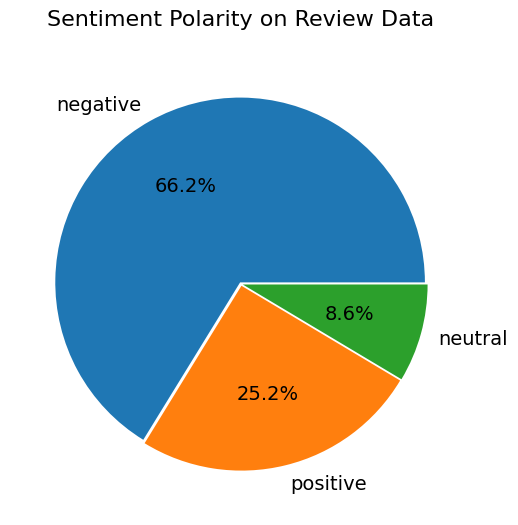

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in reviews['polarity'].value_counts()]
labels = list(reviews['polarity'].value_counts().index)
explode = [0.01] * len(labels)

# Autopct = menampilkan persentase di dalam setiap potongan pie.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

### **Make DataFrame for Each Polarity**

In [235]:
# Membuat DataFrame baru 'positive_reviews' yang hanya berisi review dengan polaritas positif.
positive_reviews = reviews[reviews['polarity'] == 'positive']
positive_reviews = positive_reviews[['content','text_akhir', 'polarity_score', 'polarity']]
positive_reviews = positive_reviews.sort_values(by='polarity_score', ascending=False)
positive_reviews = positive_reviews.reset_index(drop=True)
positive_reviews.index += 1
positive_reviews.head()

,content,text_akhir,polarity_score,polarity
1,"Terus dukung akun-akun yang kreatif yang mengasih maanfaat buat orang banyak, kalo sekiranya itu kreatif dan bermanfaat tolong tayagin selama-lamanya dan sebanyak-banyaknya, karena mencari ide kreatif yang berilmu itu sulit, jadi tolong hargai karya konten kreator. Terimakasih",dukung akun akun kreatif mengasih maanfaat kreatif bermanfaat tolong tayagin banyaknya mencari ide kreatif berilmu sulit tolong harga karya konten pencipta terima kasih,36,positive
2,"TikTok adalah platform media sosial berbasis video pendek yang memungkinkan pengguna mengekspresikan kreativitas mereka melalui musik, tarian, komedi, hingga konten edukasi. Aplikasi ini populer di berbagai kalangan karena fitur editing yang mudah, filter menarik, serta algoritma cerdas yang menampilkan video sesuai minat pengguna. TikTok menjadi wadah bagi siapa saja untuk berbagi ide, hiburan, & tren terbaru secara cepat dan viral. pengalaman baru upload gambar, vidio dan juga belum ada hasil",platform media sosial berbasis video pendek pengguna mengekspresikan kreativitas musik tarian komedi konten edukasi aplikasi populer kalangan fitur penyuntingan mudah filter menarik algoritma cerdas menampilkan video sesuai minat pengguna wadah berbagi ide hiburan trend terbaru cepat viral pengalaman unggah gambar video hasil,35,positive
3,hai nama saya gres tiktok ini sangat enak dari pada like trimakasih yang udah membuatnya ya aku kasih bintang 💗💗💗💗💗 5 ya makasih banyak ya😘😘😘😘😘aku tambah suka dari pada like makasih makasih banyak yang membuatnya kelian harus instal karena #dirumahaja# karena @viruscorona thank you,hai nama gres enak suka terima kasih membuatnya bri bintang terima kasih suka suka terima kasih terima kasih membuatnya kelian pasang terima kasih,33,positive
4,"Satu media yang bisa diakses dengan mudah dan menyediakan sarana dan prasarana gratis bagi setiap orang untuk mengembangkan bakat dan kreativitasnya yang menghasilkan karya2 original, sekaligus bisa menghasilkan rezeki. Luar biasa salut untuk TikTok. Semoga bisa terus memberikan, mempertahankan dan mengembangkan pelayanan nya kepada setiap orang.",media diakses mudah menyediakan sarana prasarana gratis mengembangkan bakat kreatif menghasilkan karya orisinal menghasilkan rezeki salut semoga mempertahankan mengembangkan pelayanan,31,positive
5,"Baguslah untuk mencari berbagai macam jenis hiburan dan lain sebagainya juga untuk menambah wawasan terimakasih tik tok saya tambahkan komentar saya disini saya suka dengan kajian kajian yang sangat bermanfaat terutama Ustadz Ustadz kondang, sekali lagi saya ucapkan terima kasih Tik tok.",baguslah mencari jenis hiburan menambah wawasan terima kasih tambahkan komentar suka kajian kajian bermanfaat ustadz ustadz kondang ucapkan terima bri,31,positive


In [48]:
# Membuat DataFrame baru 'negative_reviews' yang hanya berisi tweet dengan polaritas negatif.
negative_reviews = reviews[reviews['polarity'] == 'negative']
negative_reviews = negative_reviews[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_reviews = negative_reviews.sort_values(by='polarity_score', ascending=True)
negative_reviews = negative_reviews[0:10]
negative_reviews = negative_reviews.reset_index(drop=True)
negative_reviews.index += 1
negative_reviews.head()

,text_akhir,polarity_score,polarity,text_stopword
1,iklan tai bau curang program catur tantang berani tidak_lawan main langkah iklan kalah dasar pengecut curang curi poin persentase tidak_tahu program kesel klu tidak_bisa program pergi game catur dasar bego kesel hujat pengecut lawan catur dasar catur brengsek kaya tai,-54,negative,"[iklan, tai, bau, curang, program, catur, tantang, berani, tidak_lawan, main, langkah, iklan, kalah, dasar, pengecut, curang, curi, poin, persentase, tidak_tahu, program, kesel, klu, tidak_bisa, program, pergi, game, catur, dasar, bego, kesel, hujat, pengecut, lawan, catur, dasar, catur, brengsek, kaya, tai]"
2,kesalahan kesalahan fatal menikmati video aplikasi tidak_berfungsi masuk aplikasi aplikasi menolak mati kejadian berulang ulang terpaksa meng uninstal aplikasi mendownload aplikasi aplikasi rusak tidak_tahu tolong developer tik tok tolong perbaiki aplikasi tik tok terima kasih,-53,negative,"[kesalahan, kesalahan, fatal, menikmati, video, aplikasi, tidak_berfungsi, masuk, aplikasi, aplikasi, menolak, mati, kejadian, berulang, ulang, terpaksa, meng, uninstal, aplikasi, mendownload, aplikasi, aplikasi, rusak, tidak_tahu, tolong, developer, tik, tok, tolong, perbaiki, aplikasi, tik, tok, terima, kasih]"
3,si orng bilang aplikasi burik boong haiyukkkk kasihani apknya risih banget comentnan gitu marah gara comentnan kurang_sopan kurang_bagus aplikasi bagus deh coment bagus bagus coment jelek jelek tidak_pakai aplikasi burik boong haiyukkkkk iiii risih bilang gitu hampur aplikasi dibilang gitu tiktoknya bagus teman-teman,-50,negative,"[si, orng, bilang, aplikasi, burik, boong, haiyukkkk, kasihani, apknya, risih, banget, comentnan, gitu, marah, gara, comentnan, kurang_sopan, kurang_bagus, aplikasi, bagus, deh, coment, bagus, bagus, coment, jelek, jelek, tidak_pakai, aplikasi, burik, boong, haiyukkkkk, iiii, risih, bilang, gitu, hampur, aplikasi, dibilang, gitu, tiktoknya, bagus, teman-teman]"
4,aplikasi gajelas bangke dikit dikit kena sb dikit dikit pelanggaran dikit dikit peringatan aplikasi sportif dikit user akun normal kena ban bego admin aplikasi internasional mikir dikit yaelah,-47,negative,"[aplikasi, gajelas, bangke, dikit, dikit, kena, sb, dikit, dikit, pelanggaran, dikit, dikit, peringatan, aplikasi, sportif, dikit, user, akun, normal, kena, ban, bego, admin, aplikasi, internasional, mikir, dikit, yaelah]"
5,tidak_jelas normal download lancar download ulang tidak_bisa buka aplikasi tertera open sistem tidak_muncul nyoba buka aplikasi ketiga tidak_bisa open play store tidak_bisa open hadeh gini aplikasi kebanyakan tingkah device lawas dikit tinggalkan tidak_mandang versi android sdk tidak_cukup arsitektur minimal arm gpu high hadeh males netep ig enak payah,-47,negative,"[tidak_jelas, normal, download, lancar, download, ulang, tidak_bisa, buka, aplikasi, tertera, open, sistem, tidak_muncul, nyoba, buka, aplikasi, ketiga, tidak_bisa, open, play, store, tidak_bisa, open, hadeh, gini, aplikasi, kebanyakan, tingkah, device, lawas, dikit, tinggalkan, tidak_mandang, versi, android, sdk, tidak_cukup, arsitektur, minimal, arm, gpu, high, hadeh, males, netep, ig, enak, payah]"


In [188]:
# Membuat DataFrame baru 'neutral_reviews' yang hanya berisi tweet dengan polaritas netral.
neutral_reviews = reviews[reviews['polarity'] == 'neutral']
neutral_reviews = neutral_reviews[['content', 'text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_reviews = neutral_reviews.sort_values(by='polarity_score', ascending=True)
neutral_reviews = neutral_reviews[0:10]
neutral_reviews = neutral_reviews.reset_index(drop=True)
neutral_reviews.index += 1
neutral_reviews.head(10)

,content,text_akhir,polarity_score,polarity,text_stopword
1,"Abis update knp malah jadi aneh sih, gabisa liat barang di shop nya, tau gtu gausa di update",habis perbarui aneh tidak_bisa lihat barang toko gausa perbarui,0,neutral,"[habis, perbarui, aneh, tidak_bisa, lihat, barang, toko, gausa, perbarui]"
2,saya kasih bintang 1 karena tiktok banyak bug nya contoh punya saya mau liat tiktok. malah gak bisa masukkk,bri bintang galat contoh lihat tidak_bisa masuk,0,neutral,"[bri, bintang, galat, contoh, lihat, tidak_bisa, masuk]"
3,stuck d logo mau hapus poto yng udah d upload malah ngefreez,macet hapus foto unggah,0,neutral,"[macet, hapus, foto, unggah]"
4,"Hai tik tok, videonya banyak, bagus bagus, tapi kenapa setiap membuka link video tiktok, videonya selalu berubah, tolong diperbaiki",hai video bagus bagus membuka tautan video video berubah tolong diperbaiki,0,neutral,"[hai, video, bagus, bagus, membuka, tautan, video, video, berubah, tolong, diperbaiki]"
5,Gitu ama tiktok nyari keuntungan.. Buat even ramadhan terus seluruh item nya sold out semua dan gak ada pemberitahuan dari awa. . . Mantap lanjutkan😒,mencari keuntungan acara ramadan hitam sold tidak_ada pemberitahuan awa mantap lanjutkan,0,neutral,"[mencari, keuntungan, acara, ramadan, hitam, sold, tidak_ada, pemberitahuan, awa, mantap, lanjutkan]"
6,"Kenapa tidak bisa buka tiktok & setiap mau buat account yang sudah ada / buat lagi selalu ada tulisan""ups, account mu sedang di tangguhkan sementara""??itu kenapa accountku & kapan bisa normal lagi ,tolong kasih tau Kalau sudah bisa masuk / normal lagi seperti biasa saya kasih ⭐⭐⭐⭐⭐",tidak_bisa buka akun tulisan ups akun mu tangguhkan accountku normal tolong bri masuk normal bri,0,neutral,"[tidak_bisa, buka, akun, tulisan, ups, akun, mu, tangguhkan, accountku, normal, tolong, bri, masuk, normal, bri]"
7,kenapa setelah update pasti selalu stuck logo saja jadi macet dan gabisa diapain² lagi,perbarui macet macet tidak_bisa diapakan,0,neutral,"[perbarui, macet, macet, tidak_bisa, diapakan]"
8,tidak bisa live di wilayah indonesia,tidak_bisa siaran langsung wilayah indonesia,0,neutral,"[tidak_bisa, siaran, langsung, wilayah, indonesia]"
9,gak bisa di bukak,tidak_bisa buka,0,neutral,"[tidak_bisa, buka]"
10,kenapa tiktok gak bisa selalu dibuka gimana caranya supaya bisa mengatasi nya kasih tau caranya,tidak_bisa buka atasi bri,0,neutral,"[tidak_bisa, buka, atasi, bri]"


In [ ]:
plt.figure(figsize=(8, 4))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=reviews, palette='pastel', hue='polarity', legend=False)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Visualize text length distribution
reviews['text_length'] = reviews['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(reviews['text_length'])
plt.title('Text Length Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [21]:
X = reviews['text_akhir']
y = reviews['polarity']

In [22]:
# encoding labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# **Skema 1 (DL)**
Training: Bidirectional LSTM

Feature Extraction: Tokenizer + Embedding Layer (Trainable)

Data Splitting: 80/20

In [256]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [191]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [192]:
# --- Tokenisasi ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)


In [193]:
# --- Model LSTM ---
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_lstm.build(input_shape=(None, 100))
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     2,566,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,674,051 (10.20 MB)

 Trainable params: 2,674,051 (10.20 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callbacks to improve training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [195]:
history1 = model_lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 235s 207ms/step - accuracy: 0.8428 - loss: 0.4243 - val_accuracy: 0.8967 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 264s 209ms/step - accuracy: 0.9202 - loss: 0.2253 - val_accuracy: 0.9059 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 268s 214ms/step - accuracy: 0.9423 - loss: 0.1558 - val_accuracy: 0.9113 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 261s 213ms/step - accuracy: 0.9572 - loss: 0.1086 - val_accuracy: 0.9191 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 258s 210ms/step - accuracy: 0.9676 - loss: 0.0857 - val_accuracy: 0.9212 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9738 - loss: 0.0678
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 276s 222ms/st

In [196]:
loss, acc = model_lstm.evaluate(X_test_seq, y_test, verbose=1)
print(f"\nTesting Accuracy: {acc*100:.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9185 - loss: 0.2679

Testing Accuracy: 91.85%


In [197]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_prob = model_lstm.predict(X_val_seq)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_val, y_pred, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_val, y_pred))

235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9665    0.9593    0.9629      4967
           1     0.5992    0.7009    0.6461       642
           2     0.9225    0.8874    0.9046      1891

    accuracy                         0.9191      7500
   macro avg     0.8294    0.8492    0.8379      7500
weighted avg     0.9240    0.9191    0.9211      7500


=== Confusion Matrix ===
[[4765  144   58]
 [ 109  450   83]
 [  56  157 1678]]


# **Skema 2**
Training: Random Forest

Ekstraksi Fitur: Count Vector

Pembagian Data: 80/20

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [24]:
# 1. Pembagian Data 80/20
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_rf = tfidf_vectorizer.fit_transform(X_train_rf)
X_test_rf = tfidf_vectorizer.transform(X_test_rf)

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
y_train_pred_rf = rf_model.predict(X_train_rf)  # Prediksi untuk training set
y_test_pred_rf = rf_model.predict(X_test_rf)    # Prediksi untuk testing set

# 6. Evaluasi model
train_accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)

print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

Accuracy on Training Set: 0.9997
Accuracy on Test Set: 0.8369


# **Skema 3**

Training: SVM

Feature Extraction: TF-IDF

Data Splitting: 70/30

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [34]:
# 1. Pembagian Data 70/30
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_svm = tfidf_vectorizer.fit_transform(X_train_svm)
X_test_svm = tfidf_vectorizer.transform(X_test_svm)


In [39]:
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel untuk SVM
svm_model.fit(X_train_svm, y_train_svm)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [41]:
y_train_pred_svm = svm_model.predict(X_train_svm)  # Prediksi untuk training set
y_test_pred_svm = svm_model.predict(X_test_svm)    # Prediksi untuk testing set

# 6. Evaluasi model
train_accuracy = accuracy_score(y_train_svm, y_train_pred_svm)
test_accuracy = accuracy_score(y_test_svm, y_test_pred_svm)

print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

Accuracy on Training Set: 0.9349
Accuracy on Test Set: 0.9043


# **Skema 4 (DL)**
Pelatihan: Bidirectional GRU

Ekstraksi Fitur: Tokenizer + Embedding Layer (Trainable)

Pembagian Data: 70/30

In [216]:
# --- Model GRU ---
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    Embedding(input_dim=vocab_size3, output_dim=128),
    Bidirectional(GRU(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_gru.build(input_shape=(None, 100))
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 128)       │     2,347,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,083 (9.27 MB)

 Trainable params: 2,430,083 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

In [217]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callbacks to improve training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [218]:
history3 = model_gru.fit(
    X_train_seq3, y_train3, 
    validation_data=(X_val_seq3, y_val3), 
    epochs=10, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 219s 226ms/step - accuracy: 0.8395 - loss: 0.4371 - val_accuracy: 0.8853 - val_loss: 0.3092 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 216s 230ms/step - accuracy: 0.9208 - loss: 0.2196 - val_accuracy: 0.9069 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 231ms/step - accuracy: 0.9450 - loss: 0.1509 - val_accuracy: 0.9118 - val_loss: 0.2524 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 229ms/step - accuracy: 0.9546 - loss: 0.1187 - val_accuracy: 0.9146 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9662 - loss: 0.0900
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
938/938 ━━━━━━━━━━━━━━━━━━━━ 263s 231ms/step - accuracy: 0.9651 - loss: 0.0922 - val_accuracy: 0.9045 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 252s 219ms/step - accuracy:

In [219]:
loss, acc = model_gru.evaluate(X_val_seq3, y_val3, verbose=1)
print(f"\nTesting Accuracy: {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9118 - loss: 0.2524

Testing Accuracy: 91.18%
